# AlexNet

## Overview

📌 One of the first papers concerning CNNs as neural network architecture for image data. CNNs have much fewer parameters and connections to train compared to standard neural networks.


📌 At the time of writing, computer processing constraints made this something that had to highly optimised, split across GPUs. These parts will be omitted.


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

The data used in the paper was ImageNet.

> ImageNet is a dataset of over 15 million labelled high resolution images, belonging to around 22000 categories. The images were taken from the internet and labelled via Mechanical Turk.
> 

This notebook will use CIFAR-10 since it is more easily accessible for testing purposes.

In [8]:
def load_train_valid_sets(data_dir='./data', valid_split=0.1, batch_size=256):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    trainset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=True, download=True)
    
    
    train_size = int(len(trainset)*(1 - valid_split))
    valid_size = len(trainset) - train_size
    train, valid = torch.utils.data.random_split(trainset, [train_size, valid_size])
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    
    classes = {k : trainset.classes[k] for k in range(len(trainset.classes))}
    
    return train_loader, valid_loader, classes

In [ ]:
def load_test_sets(data_dir='./data', batch_size=64):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    testset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=False, download=True)
    
    
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

    return test_loader

In [9]:
train_loader, valid_loader, classes = load_train_valid_sets()

Files already downloaded and verified


In [10]:
test_loader = load_test_sets()

Files already downloaded and verified


### CIFAR-10 Visualisation

In [ ]:
#random sample the dataset and plot on of the pictures
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
cols, rows = 4,4
fig,ax = plt.subplots(rows, cols,figsize=(10,10))
for i in range(rows):
    images, labels = data_iter.next()
    for j in range(cols):
        ax[i][j].axis("off")
        ax[i][j].imshow(images[j].squeeze().permute(1, 2, 0))
        ax[i][j].set_title(f'Label: {classes[labels[j].item()]}')

## Architecture

The network contains eight learned layers:

- 5 convolutional layers
- 3 fully connected layers

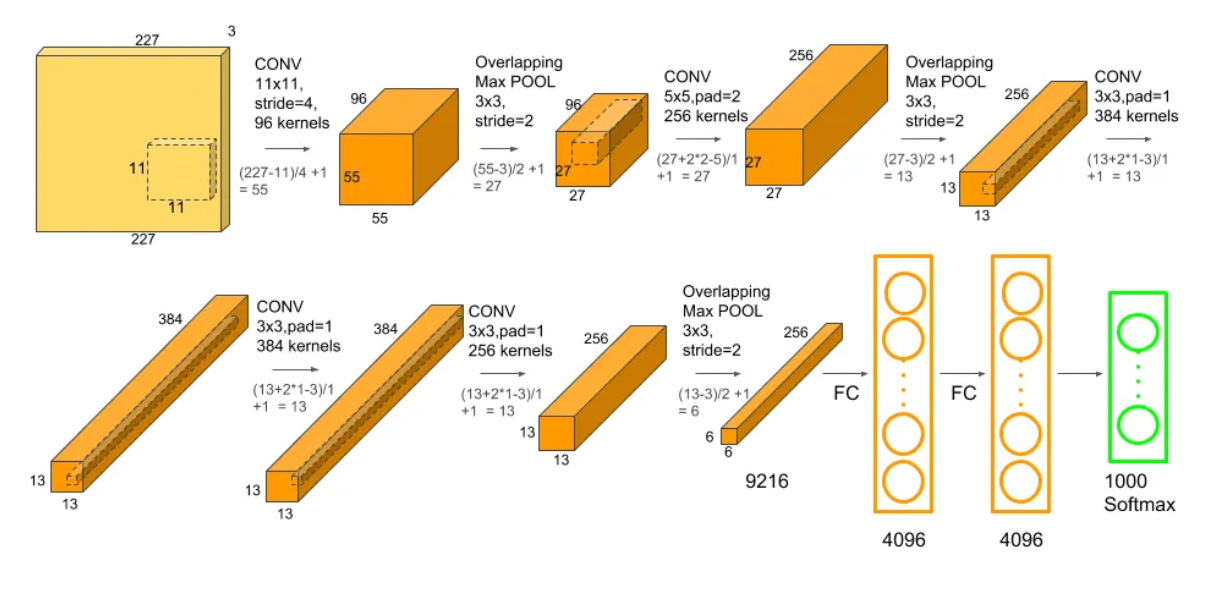

### Novel Techniques

#### ReLU Nonlinearity

Saturating non linearities are much slower to train via gradient descent than non-saturating non linearities.

ReLU stands for Rectified Linear Units:

$$
f(x)=max(0,x)
$$

ReLUs do not need input normalisation to prevent them from saturating. If at least some training examples produce a positive input to a ReLU, learning will happen in that neuron.

#### Local Response Normalisation

Despite the boons of ReLU functions, local normalisation schemes helps with generalisation. In this notebook batch normalisation is used instead.

#### Overlapping Pooling

Pooling layers summarise the outputs of neighbouring groups of neurons in the same kernel map. If we set the stride length to be smaller than the size of the pooling neighbourhood, then this is called overlapping pooling. Generally it was found that by doing this it was harder to overfit.

#### Dropout

Dropout simulates the combination of many different models, and involves setting to zero the output of each hidden neuron with a defined probability. These neurons do not contribute to the forward pass and do not participate in the backwards pass.

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, stride=4, kernel_size=11, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(3,2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, stride=1, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(3,2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, stride=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, stride=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, stride=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )

        self.layer6 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
        
    
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.layer6(x)

        return x

## Details of Learning

- Stochastic Gradient Descent:
    - momentum = 0.9
    - weight decay = 0.0005
- Weights were initialised from a zero-mean gaussian distribution with standard deviation 0.01.

In [12]:
import torch.optim as optim

net = AlexNet(len(classes))

learning_rate = 0.005

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

# Train the model
total_step = len(train_loader)

In [13]:
num_epochs = 1
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        if (i + 1) == 500:
            break

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/1], Step [10/79], Loss: 2.3005
Epoch [1/1], Step [20/79], Loss: 2.0521
Epoch [1/1], Step [30/79], Loss: 2.1352
Epoch [1/1], Step [40/79], Loss: 1.9375
Epoch [1/1], Step [50/79], Loss: 1.8465
Epoch [1/1], Step [60/79], Loss: 1.6588
Epoch [1/1], Step [70/79], Loss: 1.7038
Epoch [1/1], Step [79/79], Loss: 1.3249
Accuracy of the network on the 5000 validation images: 34.33555555555556 %


In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

NameError: name 'test_loader' is not defined